<a href="https://colab.research.google.com/github/christopher-reed/UCLA-New-Mexico/blob/master/Technical_Appendix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![UCLA IoES Practicum 2019 - 2020](https://drive.google.com/uc?id=1ok9wr5sJOxcLFjiNutmrxhNa8-lHJ3IM)
The goal of this notebook is to detail the workflow that allows us to detect potential permitting violations.

# Final Analysis

## Install and import packages

In order to perform this analysis we used a number of Python's standard data science packages. The most crucial of which were Pandas, NumPy, Matplotlib, and Scikit Learn. In addition to these standard packages, it was also necessary to use geospatial packages such as geopandas and fiona to read and process geospatial data. Documentation for the most prominent packages can be found below.

![Primary Data Science Packages](https://drive.google.com/uc?id=1XmpTYjrUTqtSMllT-4CXgbzofKUQ76L8)

* [Pandas](https://pandas.pydata.org/)
* [NumPy](https://numpy.org/)
* [Matplotlib](https://matplotlib.org/)
* [Scikit-learn](https://scikit-learn.org/stable/)
* [Geopandas](https://geopandas.org/)
* [Fiona](https://fiona.readthedocs.io/en/latest/manual.html)

**Install packages (fiona, geopandas) that are not preloaded into Google Colab.**

In [0]:
#Suppress outbook with inline magic
%%capture
!pip install fiona
!pip install geopandas

**Import packages.**

In [0]:
#Suppress outbook with inline magic
%%capture

from ftplib import FTP
import requests
import time
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation, rc
import datetime
import seaborn as sns
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

**In order for matplotlib's Basemap to function with Google Colab, we must run the following lines which revert to earlier pacakge versions.**

In [0]:
%%capture

##For Basemap to work in Google Colab
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install pyproj==1.9.6

**Now we can import Basemap.**

In [0]:
#Now we can import these
from mpl_toolkits.basemap import Basemap

##Data collection

There are two data sources required for this analysis: the New Mexico Environment Department (NMED) and the New Mexico Oil Conservation Division (NMOCD). The NMED houses all the facility information including the location, emissions, and permitting information. The NMOCD houses all the well information including the location, operating company, and the dates of major events such as spudding.

![Data Sources](https://drive.google.com/uc?id=1nUxwCt5hgL3nraEmmI9GuprWv8EZKpNs)

**The New Mexico Oil Conservation Division**

The NMOCD has a geospatial dataset of all the wells in New Mexico that is updated biweekly. The dataset is available for download on the [NMOCD FTP website](ftp://164.64.106.6/Public/OCD/OCD%20GIS%20Data/). The dataset is located under the Geodatabase folder. The NMOCD also provides metadata on the dataset as well as updates on the status of the FTP site.

**The New Mexico Environment Department**

The NMED maintains a running list of permitted faiclities across New Mexico. The datset is stored as an Excel file and is located on the ["Current Permitting Activities"](https://www.env.nm.gov/air-quality/aqb-p_current_permitting_activites/) page on their website. At the time this appendix was created, the Excel spreadsheet was hyperlinked with the name "Permitted Facilities Lat/Long as of 02/24/2020." 

While the NMED dataset of facilities provides  information such as the location and emissions, it fails to explicity list crucial information about the permits. In order to obtain permitting information about each facility, it is necessary to file public records request for specific facilities with the NMED. This step will be covered in greater detail later in the analysis.

### Obtain OCD Well Data

The following code allows one to download the most recent version of the OCD well dataset by directly interfacing with the FTP site. The data is saved as a geodatabase and it is necessary to use software such as ArcMap or Python packages like geopandas to read the file.

Although the FTP site works often, we have found that the site occassionaly is unavailable for connection. In the event a connection cannot be made, we use the most recent downloaded dataset which during the time this technical appenidx was created is April 25th, 2020.

In [0]:
# # Remove comments if desire to download the latest well dataset from the OCD
# # Connect to FTP
# ftp = FTP('164.64.106.6')
# ftp.login()

# #Move to directory
# ftp.cwd('/Public/OCD/OCD GIS Data/Geodatabase/')

# #Download file
# file = 'NMOCD_GISData.gdb.zip'
# ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

# #Unzip the geodatabase
# !unzip /content/NMOCD_GISData.gdb.zip

# #Parse feature class from gdb
# df_wells = gpd.read_file('/content/NMOCD_GISData.gdb', layer = 'WellGIS')

# #Convert spud date column to datetime.
# df_wells['spud_date'] = pd.to_datetime(df_wells['spud_date'], errors = 'coerce')

# #Remove excess white space
# df_wells['type_code'] = df_wells['type_code'].str.replace(' ', '')

# #Only want wells in SAN JUAN COUNTY that are ACTIVE and operated by HILCORP or ENDURING
# df_san_juan = df_wells[(df_wells['county'] == 'San Juan') &
#                         (df_wells['ogrid'].isin([120782, 372286, 372171]))&
#                         (df_wells['status'] == 'Active')]

# #Save raw data
# df_wells.to_csv('nm_wells.csv')
# df_san_juan.to_csv('sanjuan_active_wells.csv')

#INCASE OF FTP VERSION USE GEODATABASE DOWNLOADED 25 APRIL 2020###
df_wells = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Wells/nm_wells.csv')

#Convert spud date column to datetime.
df_wells['spud_date'] = pd.to_datetime(df_wells['spud_date'], errors = 'coerce')

#Remove excess white space
df_wells['type_code'] = df_wells['type_code'].str.replace(' ', '')

#Year spudded is currently a character. Change to numeric.
df_wells['year_spudded'] = pd.to_numeric(df_wells['year_spudded'])

# #Only want wells in SAN JUAN COUNTY that are ACTIVE and operated by HILCORP or ENDURING
# df_san_juan = df_wells[(df_wells['county'] == 'San Juan') &
#                         (df_wells['ogrid'].isin([120782, 372286, 372171]))&
#                         (df_wells['status'] == 'Active')]

#Inspect well data
df_wells.head()

,Unnamed: 0,id,name,type_code,type,status_code,status,ogrid,ogrid_name,district_code,district,county_code,county,ulstr,latitude,longitude,projection,directional_status,details,files,status2,symbology,year_spudded,spud_date,measured_vertical_depth,true_vertical_depth,pool_id_list,effective_date,plug_date,GlobalID,geometry
0,0,30-045-11589,GALLEGOS CANYON UNIT #208,G,Gas,A,Active,778,BP AMERICA PRODUCTION COMPANY,3,Aztec,45,San Juan,H-15-28N-12W,36.664745,-108.093590,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,1965.0,1965-11-20,6165.0,6155.0,[50380] PINON GALLUP; [71599] BASIN DAKOTA (PR...,2002-01-22T00:00:00,9999-12-31T00:00:00,{123B0943-AD8F-4F44-8008-293000B1889D},POINT (-108.0935898 36.66474530000005)
1,1,30-015-38510,WELCH RL STATE #008E,O,Oil,C,Cancelled,281994,"VANGUARD OPERATING, LLC",2,Artesia,15,Eddy,D-28-17S-28E,32.810548,-104.188218,NAD83,,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,C,OC,9999.0,NaT,0.0,0.0,"[96830] ARTESIA, GLORIETA-YESO (O)",2013-03-02T00:00:00,9999-12-31T00:00:00,{147ABB20-991B-46FE-922D-57C02BAEA673},POINT (-104.1882184199999 32.81054771000004)
2,2,30-025-22024,COTTON DRAW SWD #066,S,Salt Water Disposal,P,Plugged (site released),161968,"MESQUITE SWD, INC",1,Hobbs,25,Lea,E-10-25S-32E,32.146522,-103.669014,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,P,SP,1900.0,1900-01-01,15769.0,15769.0,"[96802] SWD, BELL CANYON-CHERRY CANYON",2014-01-07T00:00:00,2019-09-23T00:00:00,{B532CCD1-F5C5-4CFE-AF58-F35A3BB5275C},POINT (-103.6690139999999 32.14652250000006)
3,3,30-039-22944,GALLO WHITE #001,O,Oil,P,Plugged (site released),6515,DUGAN PRODUCTION CORP,3,Aztec,39,Rio Arriba,J-14-23N-06W,36.222492,-107.435852,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,P,OP,1980.0,1980-05-02,5566.0,5566.0,[13379] COUNSELORS GALLUP-DAKOTA,1994-02-03T00:00:00,1994-02-16T00:00:00,{DD9390A0-96EC-434A-AE5E-FA6559EC7671},POINT (-107.4358521 36.22249220000003)
4,4,30-025-01108,LAZY J B #001,O,Oil,A,Active,240974,"LEGACY RESERVES OPERATING, LP",1,Hobbs,25,Lea,P-34-13S-33E,33.142693,-103.595841,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1961.0,1961-05-20,0.0,9954.0,"[37430] LAZY J, UPPER PENN",2013-10-17T00:00:00,9999-12-31T00:00:00,{4085CC9C-9A88-4A7B-913B-A504ADF257EF},POINT (-103.5958405 33.14269260000003)


### Obtain NMED Facilities Data

Unlike the NMOCD data, the NMED Facilities data must be manually downloaded from the site described and linked earlier.

In [0]:
#Read in downloaded facilities data
facilities = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Facilities/AQBP-LatLong-20-01-06.csv')

#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

## Exploratory Analysis of Wells and Facilities

Before we begin the analysis, it is important to get a sense of the data we are working with through an exploratory data analysis. The exploration will be guided by the following questions...

* How extensive is the development of oil and gas wells across New Mexico? San Juan county?
* What is the trend in well spuds across New Mexico? San Juan county?
* What operating companies are responsible for the most recent wells in San Juan County, New Mexico?

The code cells below detail how to perform the analysis, but the figures and results are summarized here.

![Spuds in New Mexico](https://drive.google.com/uc?id=1MODlEz8J-s4HpoIwYkQnchVrGfs9g01o)

The above animated plot illustrates that there has been extensive growth in oil wells across New Mexico since 1900. There are two primary regions of development: the northwest and southeast corners. The northwest corner is where the San Juan Basin is located. The southeast corner is where the Permian Basin is located. For the purposes of this project, we will be focusing on the San Juan Basin.


---


![Spuds in San Juan County](https://drive.google.com/uc?id=10jqIUsDAUmjOLXiiUpZ5jf0htdscRRD9)

As visualized in the previous plot, there has been extensive oil and gas well devleopment in San Juan County which is outlined in the bold black line. A significant portion of this development has occurred on or in close proximity to federally recognized indigenous land. The proximity of development to indigenous land raises concerns over the health impacts in those communities. 


---


![Spuds in New Mexico](https://drive.google.com/uc?id=1wlGyEryqzOoDF8n5nVIpwC7oynAl574o)

The above plot demonstrates that there have been three peaks in development in San Juan county. It appears as though oil and gas well development has slowed in the past 10 years. This is likely due to the recent explosion of development in the Permian Basin located in the opposite corner of New Mexico.


**What is the general trend in Spud dates overtime in New Mexico regardless of operating company? We exclude the year 1900 because wells with this date are pre-ongard.**

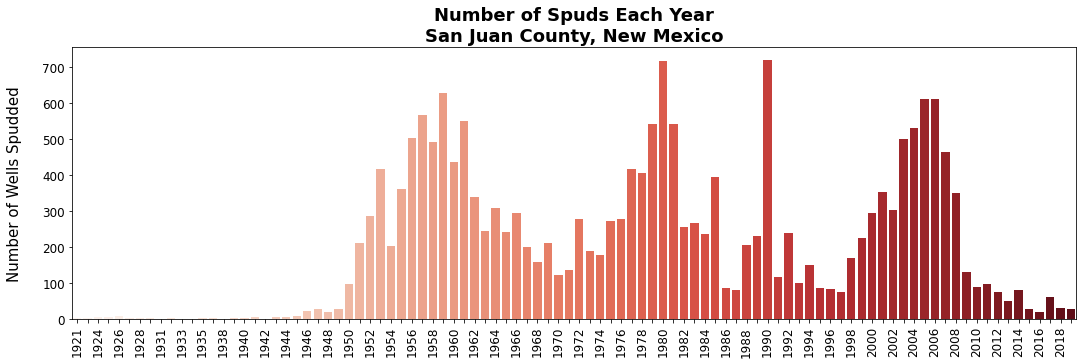

In [0]:
#Filter to only wells in San Juan County that were spudded after 1900
df_wells_plot = df_wells[(df_wells['spud_date'].dt.year > 1900) & (df_wells['county'] == 'San Juan')]

#Group by years and count the spuds in each year
count_spuds = df_wells_plot.groupby(df_wells_plot['spud_date'].dt.year).count()
count_spuds= count_spuds.rename(columns = {'spud_date':'Num Spuds'})
count_spuds = count_spuds.reset_index()

#Barplot
fig, ax = plt.subplots(figsize = (18,5))
ax = sns.barplot(x = 'spud_date', y = 'Num Spuds', data = count_spuds, palette = 'Reds')
plt.xticks(rotation = 90)

#Format labels 
ax.set_title('Number of Spuds Each Year\nSan Juan County, New Mexico', size = 18, weight = 'bold')
ax.set_xlabel('')
ax.set_ylabel('Number of Wells Spudded', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

#Every other x tick label visible
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

**Visualize the total number of wells across New Mexico with an animated plot.**

In [0]:
#Create a list of dfs that each have one more year's wells than the previous df
years_list = []
for year in np.arange(1921, 2020):
  df = df_wells[(df_wells['year_spudded'] > 1920) & (df_wells['year_spudded'] < year)]
  years_list.append(df)

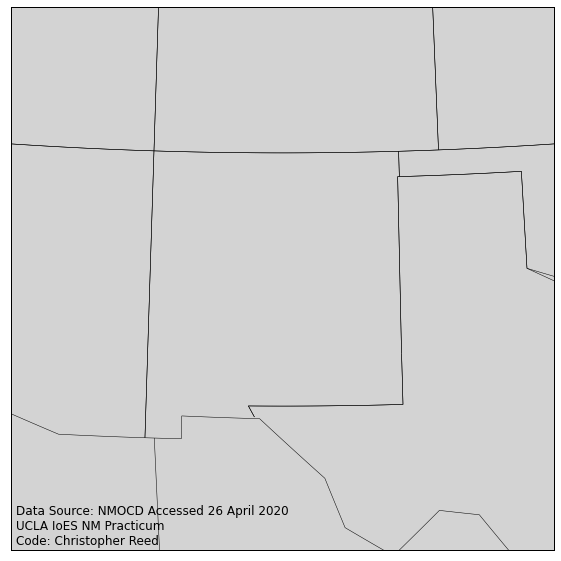

In [0]:
#Create animation that does have a basemap

#Size of plot
fig, ax = plt.subplots(figsize = (10,10))

#Create static map centered on coords lat_0 and lon_0
m = Basemap(width=1194000, height=1194000, projection='lcc',
            resolution='c', lat_0= 34.5199, lon_0=-105.8701)

#Add map elements
m.drawcoastlines()
m.drawmapboundary(fill_color='lightgrey')
m.drawstates()
m.drawcountries()

x,y = m(0, 0)
graph = m.plot(x, y, 'ro', markersize=5, alpha = 0.3)[0]
#ro
#Citation
ax.text(0.01,0.01, 'Data Source: NMOCD Accessed 26 April 2020\nUCLA IoES NM Practicum\nCode: Christopher Reed', color = 'black', size = 12, transform = ax.transAxes)

#Set params for dynamic title
title = ax.text(0.525, 0.85,'', size = 20, color = 'black', transform=ax.transAxes, ha = 'center')

def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x, y = m(years_list[i]['longitude'].values, years_list[i]['latitude'].values)
    graph.set_data(x, y)
    title.set_text(u"Spudded O&G Wells in NM\nYear: {}".format(i + 1920))
    return graph,title


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(years_list), interval=150, blit=True)

plt.show()

In [0]:
rc('animation', html='jshtml')
anim

In [0]:
#Save as a mp4
anim.save('nm_spuds.mp4')

**Zoom in on San Juan County**

In [0]:
!unzip san_juan_county.zip
!unzip indigenous_land.zip

Archive:  san_juan_county.zip
 extracting: san_juan_county/sj_county_dissolve.cpg  
  inflating: san_juan_county/sj_county_dissolve.dbf  
  inflating: san_juan_county/sj_county_dissolve.prj  
  inflating: san_juan_county/sj_county_dissolve.sbn  
  inflating: san_juan_county/sj_county_dissolve.sbx  
  inflating: san_juan_county/sj_county_dissolve.shp  
  inflating: san_juan_county/sj_county_dissolve.shp.xml  
  inflating: san_juan_county/sj_county_dissolve.shx  
Archive:  indigenous_land.zip
 extracting: indigenous_land/indigenous_land_dissolve.cpg  
  inflating: indigenous_land/indigenous_land_dissolve.dbf  
  inflating: indigenous_land/indigenous_land_dissolve.prj  
  inflating: indigenous_land/indigenous_land_dissolve.sbn  
  inflating: indigenous_land/indigenous_land_dissolve.sbx  
  inflating: indigenous_land/indigenous_land_dissolve.shp  
  inflating: indigenous_land/indigenous_land_dissolve.shp.xml  
  inflating: indigenous_land/indigenous_land_dissolve.shx  


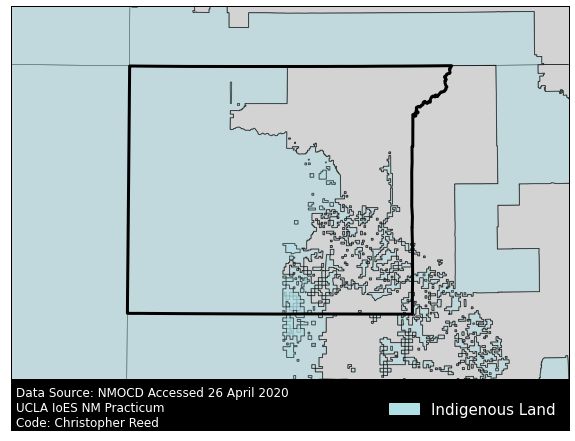

In [0]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import matplotlib.patches as mpatches
import matplotlib

#Expand animation size
matplotlib.rcParams['animation.embed_limit'] = 2**128

#Size of plot
fig, ax = plt.subplots(figsize = (10,10))

#Create static map centered on coords lat_0 and lon_0
m = Basemap(width=250000, height=190000, projection='lcc',
            resolution='c', lat_0= 36.3882, lon_0=-108.2378)

#Add map elements including shapefiles
m.drawcoastlines()
m.drawmapboundary(fill_color='lightgrey')
m.drawstates()
m.drawcountries()
m.readshapefile('indigenous_land/indigenous_land_dissolve', 'indigenous_land_dissolve')
m.readshapefile('san_juan_county/sj_county_dissolve', 'sj_county_dissolve', linewidth = 3, zorder = 10)

#Fill in the shapefile with a color
map_patches = []
for info, shape in zip(m.indigenous_land_dissolve_info, m.indigenous_land_dissolve):
  map_patches.append(Polygon(np.array(shape), True) ) 
ax.add_collection(PatchCollection(map_patches, facecolor= 'powderblue', edgecolor='k', linewidths=1., zorder=2, alpha = 0.5, label = 'Indigenous Land'))



#Citation
ax.text(0.01,0.01, 'Data Source: NMOCD Accessed 26 April 2020\nUCLA IoES NM Practicum\nCode: Christopher Reed', color = 'white', size = 12, transform = ax.transAxes, zorder = 8)


rect = patches.Rectangle((0,0), width = 1, height = 0.12,
                         linewidth = 1, edgecolor = 'black', facecolor= 'black', transform = ax.transAxes, zorder = 7)

ax.add_patch(rect)

#Create a legend.
blue_patch = mpatches.Patch(color='powderblue', label='Indigenous Land')
leg = plt.legend(handles=[blue_patch], loc = 'lower right', prop={'size': 15}, facecolor = 'none', edgecolor = 'none', )
leg.set_zorder(10)
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color('white')

#Plot points
x,y = m(0, 0)
graph = m.plot(x, y, 'ro', markersize=5, alpha = 0.3)[0]


#Set params for dynamic title
title = ax.text(0.525, 1.05,'', size = 20, color = 'black', transform=ax.transAxes, ha = 'center')

def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x, y = m(years_list[i]['longitude'].values, years_list[i]['latitude'].values)
    graph.set_data(x, y)
    title.set_text(u"Spudded O&G Wells in San Juan County, NM\nYear: {}".format(i + 1920))
    return graph,title


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(years_list), interval=150, blit=True)

plt.show()

In [0]:
anim

In [0]:
#Save as a mp4
anim.save('nm_spuds_sjcounty.mp4')

**What companies have been spudding the most in San Juan County since 2010? We are only looking at wells with a status code of active.**

Text(0.5, 1.0, 'Number of New Wells Spudded Since 2010\nSan Juan County, NM')

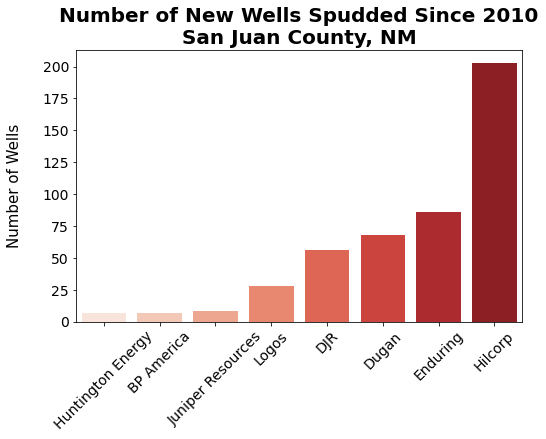

In [0]:
#Prepare data to count how many wells
df_wells_barplot = df_wells[(df_wells['county'] == 'San Juan') & (df_wells['spud_date'].dt.year > 2009) & (df_wells['status_code'] == 'A')]
df_wells_barplot = df_wells_barplot.groupby('ogrid_name').count().sort_values(by = 'id').reset_index()
df_wells_barplot = df_wells_barplot[df_wells_barplot['ogrid'] > 5]

#Create figure
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'ogrid_name', y = 'id', data = df_wells_barplot, palette = 'Reds')

#Figure formatting
ax.set_xticklabels(['Huntington Energy', 'BP America',
                    'Juniper Resources', 'Logos',
                    'DJR', 'Dugan',
                    'Enduring', 'Hilcorp'])
plt.xticks(rotation = 45)

#Labels
ax.set_xlabel('')
ax.set_ylabel('Number of Wells', size = 15, labelpad = 20)
ax.set_title('Number of New Wells Spudded Since 2010\nSan Juan County, NM', size = 20, weight = 'bold')

**What is the break down of oil or gas wells operated by Hilcorp or Enduring (top 2 spudding companies based on previous figure)?**

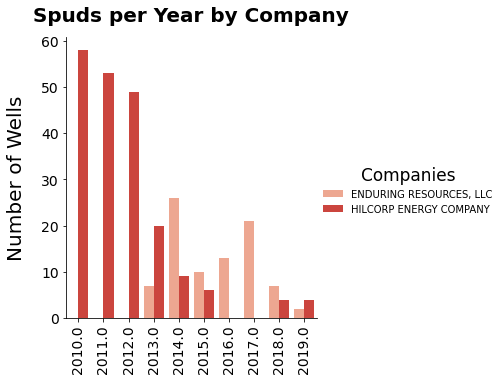

In [0]:
df_spud_hil_end = df_wells[(df_wells['county'] == 'San Juan') & (df_wells['spud_date'].dt.year > 2009) & (df_wells['status_code'] == 'A') & (df_wells['ogrid_name'].isin(['ENDURING RESOURCES, LLC','HILCORP ENERGY COMPANY']))]

#How many wells by each company?
plot =  df_spud_hil_end.groupby(['ogrid_name', 'year_spudded']).count() 
plot = plot.rename(columns = {'spud_date':'Num Spud'})
plot = plot.reset_index()

g = sns.catplot(x = 'year_spudded', y = 'Num Spud', data = plot, hue = 'ogrid_name', kind = 'bar', palette = 'Reds', legend = True)
axes = g.axes.flatten()
axes[0].set_title('Spuds per Year by Company', size = 20, weight = 'bold', pad = 15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of Wells')
plt.xticks(rotation = 90)

#Edit legend
g._legend.set_title('Companies')

## Well Clustering and Facility Association

**Split up the data**

In [0]:
#Only hilcorp wells
hilcorp = df_wells[(df_wells['county'] == 'San Juan') &
                   (df_wells['spud_date'].dt.year > 2009) &
                   (df_wells['status_code'] == 'A') &
                   (df_wells['ogrid_name'].isin(['HILCORP ENERGY COMPANY']))]
hilcorp_gas = hilcorp[hilcorp['type_code'] == 'G']
hilcorp_oil = hilcorp[hilcorp['type_code'] == 'O']

#Only enduring wells
enduring = df_wells[(df_wells['county'] == 'San Juan') &
                   (df_wells['spud_date'].dt.year > 2009) &
                   (df_wells['status_code'] == 'A') &
                   (df_wells['ogrid_name'].isin(['ENDURING RESOURCES, LLC']))]
enduring_gas = enduring[enduring['type_code'] == 'G']
enduring_oil = enduring[enduring['type_code'] == 'O']

### Enduring Gas Analysis

**First step is to visualize all the new Enduring gas wells.**

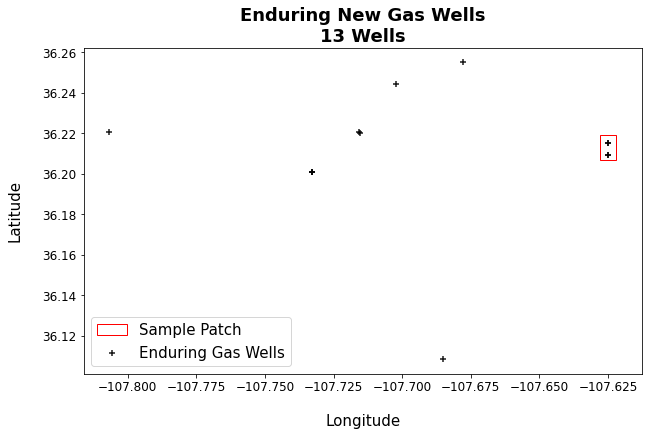

In [0]:
#Plot all new gas wells for enduring
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(enduring_gas['longitude'], enduring_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Enduring Gas Wells')

#Find the number of enduring gas wells
wells = enduring_gas.shape[0]

#Format labels
ax.set_title('Enduring New Gas Wells\n' + str(wells) + ' Wells', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#ax.legend([df_scatter,], ['Enduring Gas Wells'], loc= 'lower left', prop = {'size':15})
ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**With satellite imagery we can visualize the wells on the right hand side of the above scatterplot.**

![picture](https://drive.google.com/uc?id=1I4g6WCDGsJM1I6Yk28zAv5r1UAGh3U6L)

**The next step is to cluster wells together. Clustering is an important step because instead of associating individual wells with facilities, we can associate well clusters (only one point) with facilities. This will cut down the time it takes to run the code in the case of using MANY wells.**

**DBSCAN is a clustering algorithm that groups points together based on their density. We are only only using the coordinates to cluster points, but theoretically you could use other information**

Useful description of DBSCAN for later: https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/

In [0]:
#Matrix of all the well coordinates
coords = enduring_gas[['latitude', 'longitude']].values

#DBSCAN requires two inputs other than data: minimum number of samples per cluster and the distance to associate points
kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 8


**Now need to find the centerpoint of all the clusters determined above.**

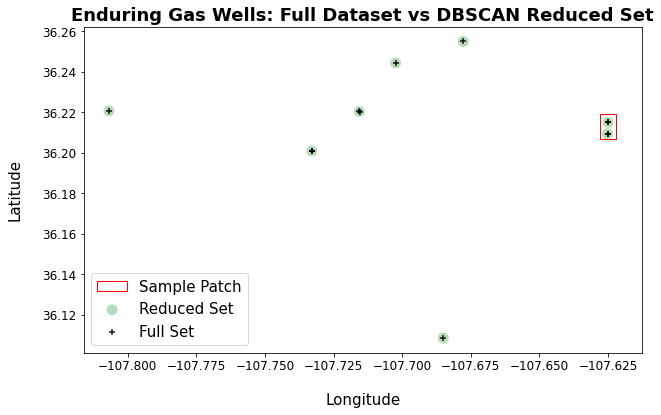

In [0]:
#Function to determine centermost points 
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

#Find centermost points in each cluster
centermost_points = clusters.map(get_centermost_point)

#Save centerpoints as a df
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})


rs = rep_points.apply(lambda row: enduring_gas[(enduring_gas['latitude']==row['lat'])&(enduring_gas['longitude']==row['lon'])].iloc[0], axis=1)

#Create plot
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Reduced Set')

#Plot individual well sites
df_scatter = ax.scatter(enduring_gas['longitude'], enduring_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Full Set')

#Sample patch
rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Gas Wells: Full Dataset vs DBSCAN Reduced Set', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)
ax.legend([df_scatter, rs_scatter], ['Gas Full set', 'Gas Reduced set'], loc='best')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**In the original dataframe of gas wells, we want to know what cluster each observation was assigned to.**

In [0]:
#Empty column to store values
enduring_gas['Cluster'] = np.nan

#Iterate through an iterable of length clusters
for i in range(len(clusters)):

  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   enduring_gas.loc[(enduring_gas['latitude'] == j[0]) & (enduring_gas['longitude'] == j[1]), ['Cluster']] = int(i)


#Do the same with our centerpoints of wells. We want to know the cluster number associated with centerpoints.
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

rs.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Unnamed: 0,id,name,type_code,type,status_code,status,ogrid,ogrid_name,district_code,district,county_code,county,ulstr,latitude,longitude,projection,directional_status,details,files,status2,symbology,year_spudded,spud_date,measured_vertical_depth,true_vertical_depth,pool_id_list,effective_date,plug_date,GlobalID,geometry,Cluster
0,8976,30-045-35538,CHACO 2308 03L #405H,G,Gas,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,L-03-23N-08W,36.255062,-107.677757,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2014.0,2014-07-08,10419.0,10329.0,[97232] BASIN MANCOS,2018-04-19T00:00:00,9999-12-31T00:00:00,{66466734-8BE9-4F7E-93D1-706C749CDEDA},POINT (-107.6777572999999 36.25506210000003),0.0
1,23640,30-045-35879,KIMBETO WASH UNIT #767H,G,Gas,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,P-17-23N-09W,36.220745,-107.806892,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2018.0,2018-09-06,0.0,0.0,[97232] BASIN MANCOS,2018-08-31T00:00:00,9999-12-31T00:00:00,{988C117B-C796-4B61-AAA8-7F1EC62A3C9C},POINT (-107.8068919999999 36.22074500000008),1.0
2,77067,30-045-35880,RODEO UNIT #509H,G,Gas,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,H-25-23N-09W,36.200941,-107.732970,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2018.0,2018-09-26,16490.0,4316.0,[97232] BASIN MANCOS,2018-08-29T00:00:00,9999-12-31T00:00:00,{ECDFF8C9-B964-4861-874B-2F589AEB9538},POINT (-107.73297 36.20094100000006),2.0
3,33150,30-045-35895,LONE MESA UNIT #001H,G,Gas,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,J-28-22N-08W,36.108471,-107.685035,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2019.0,2019-02-25,0.0,0.0,[71629] BASIN FRUITLAND COAL (GAS),2019-01-15T00:00:00,9999-12-31T00:00:00,{A541A06B-EE28-4EDF-8BCA-5B17584B5F4C},POINT (-107.685035 36.10847100000007),3.0
4,113558,30-045-35800,RODEO UNIT #501H,G,Gas,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,P-18-23N-08W,36.220442,-107.715623,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2017.0,2017-05-31,12465.0,4963.0,[97232] BASIN MANCOS,2018-04-19T00:00:00,9999-12-31T00:00:00,{8E2753B4-64AB-4E4C-9FAF-5B26CB046FD5},POINT (-107.7156229999999 36.22044200000005),4.0


**Now it is time to associate facilities with well clusters. Start by filtering the dataframe of facilities down to ones that are within the general area, are considered oil and gas facilities, and within San Juan County.**

In [0]:
#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

##Filter out outliers by max lat and lon of well locations
#Bottom right: Must be less than or equal to this
max_lon = enduring_gas['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = enduring_gas['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = enduring_gas['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = enduring_gas['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

**Visualize well clusters and facilities on the same figure.**

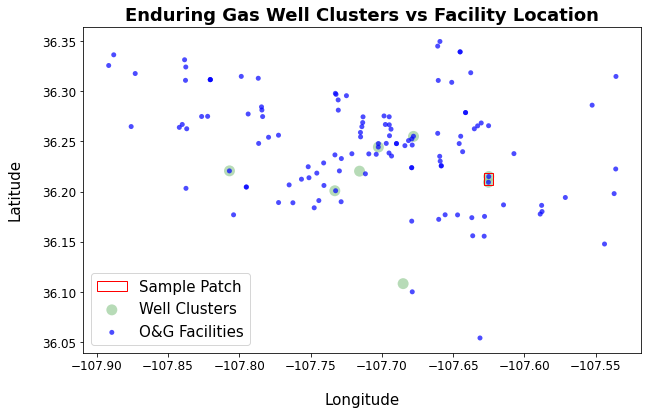

In [0]:
#Create figure
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints of well clusters
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Clusters')

#Plot filtered facilities
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Gas Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend([rs_scatter, fac_scatter], ['Gas Well Clusters', 'Facilities'], loc='upper right')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**In order to associate facilities with wells, we need to calculate the distance between each well cluster and the facility. Since the observations occur on Earth's surface, the most appropriate distance metric is Haversine.**

In [0]:
#Haversine function for distance calculation
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

**Calculate the distance between each of the well clusters and the facilities using the Haversine function. If a facility is less than 200 meters away, it is considered associated. If no facilities are found within 200 meters, store the facilities as isolated and they will be used in another analysis.**

In [0]:
#I want to have a seperate path for isolated well sites.
#So if no facilities within 200 m, I want to expand search radius to 500
#Need a running count of the number of faciliites per well

og_facilities['Cluster'] = np.nan

#How many facilities per center point?
isolated = []

#Iterate through center points
for i in rs['id'].unique():
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]
  
  count = 0

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num

      count = count + 1
      
    #Too far away to be associated
    else:
      continue

  if count == 0:
    isolated.append(i)

  else:
    continue

30-045-35538 34658 0.0
30-045-35879 36843 1.0
30-045-35880 38352 2.0
30-045-35550 33925 5.0
30-045-35551 33983 6.0
30-045-35422 35261 7.0


**Take the list of isolated facilities and crank up the distance to 500 m to find any nearby facilities.**

In [0]:
#Iterate through center points
for i in np.unique(isolated):
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 500:
      print(i, j, cluster_num)
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      #Label it with cluster number of rs center point

    #Too far away to be associated
    else:
      continue

30-045-35800 36842 4.0


**Inner join facilities and wells together based on their cluster. Inner join will remove facilities that did not have a cluster. Filter to only useful columns.**

In [0]:
#So now we can join the facilities and wells df

df_well_fac = enduring_gas.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['spud_date', 'status', 'id', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'AI', 'Facility Name', 'Cluster', 'Latitude', 'Longitude',
                                  'NO_TPY','CO_TPY','VOC_TPY','PM10_TPY','SO2_TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API',
                                    'AI':'Facility AI'})

#Save as csv
df_well_fac_filter.to_csv('enduring_gas_well_facility_match.csv')

**Visualize all the paired facilities. Note that all the well clusters are included in this plot regardless of if they are paired or not.**

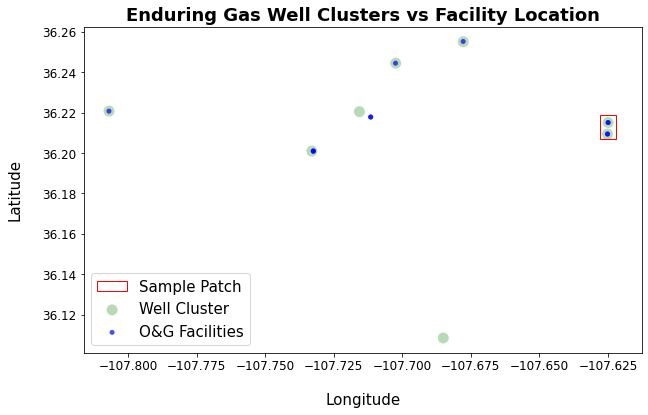

In [0]:
#Plot
fig, ax = plt.subplots(figsize= (10, 6))

#Scatter of well center points
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Cluster')

#Scatter of associated facilities
fac_scatter = ax.scatter(df_well_fac_filter['Facility Longitude'], df_well_fac_filter['Facility Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')
ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Gas Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**Visualize the sample patch of well with high resolution imagery. The DBSCAN 0.4 km buffer is included. The facility to well associationdistance (0.2 km) is not included.**

![picture](https://drive.google.com/uc?id=1AXrBnzoGz1hhhszAHywqnKNeDCXsskj5)

### Enduring Oil Analysis

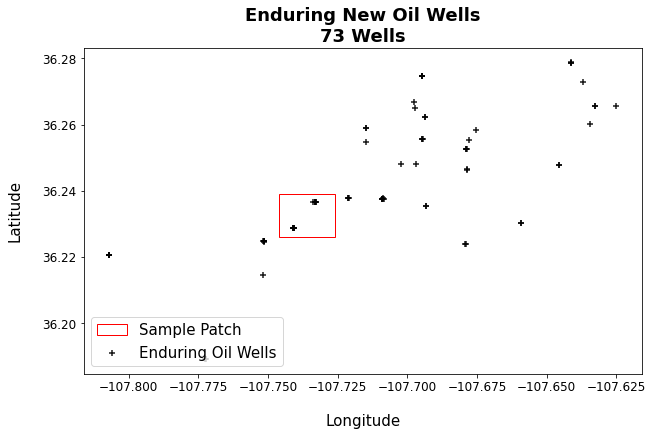

In [0]:
#Plot all new gas wells for enduring
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(enduring_oil['longitude'], enduring_oil['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Enduring Oil Wells')

#Find the number of enduring gas wells
wells = enduring_oil.shape[0]

#Format labels
ax.set_title('Enduring New Oil Wells\n' + str(wells) + ' Wells', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

rect = patches.Rectangle((-107.746, 36.226), width = 0.02, height = 0.013,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**The next step is to cluster wells together. Clustering is an important step because instead of associating individual wells with facilities, we can associate well clusters (only one point) with facilities. This will cut down the time it takes to run the code in the case of using MANY wells.**

**DBSCAN is a clustering algorithm that groups points together based on their density. We are only only using the coordinates to cluster points, but theoretically you could use other information**

Useful description of DBSCAN for later: https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/

In [0]:
#Matrix of all the well coordinates
coords = enduring_oil[['latitude', 'longitude']].values

#DBSCAN requires two inputs other than data: minimum number of samples per cluster and the distance to associate points
kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 28


**Now need to find the centerpoint of all the clusters determined above.**

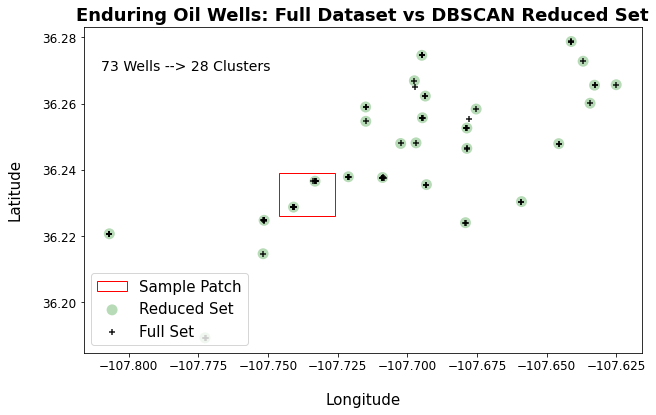

In [0]:
#Function to determine centermost points 
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

#Find centermost points in each cluster
centermost_points = clusters.map(get_centermost_point)

#Save centerpoints as a df
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})


rs = rep_points.apply(lambda row: enduring_oil[(enduring_oil['latitude']==row['lat'])&(enduring_oil['longitude']==row['lon'])].iloc[0], axis=1)

#Create plot
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Reduced Set')

#Plot individual well sites
df_scatter = ax.scatter(enduring_oil['longitude'], enduring_oil['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Full Set')

#Sample patch
rect = patches.Rectangle((-107.746, 36.226), width = 0.02, height = 0.013,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Oil Wells: Full Dataset vs DBSCAN Reduced Set', size = 18, fontweight = 'bold')
text = str(wells) + ' Wells --> ' + str(num_clusters) + ' Clusters'  
ax.text(-107.810, 36.27, text, size = 14)
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)
ax.legend([df_scatter, rs_scatter], ['Oil Full set', 'Oil Reduced set'], loc='best')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**In the original dataframe of gas wells, we want to know what cluster each observation was assigned to.**

In [0]:
#Empty column to store values
enduring_oil['Cluster'] = np.nan

#Iterate through an iterable of length clusters
for i in range(len(clusters)):

  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   enduring_oil.loc[(enduring_oil['latitude'] == j[0]) & (enduring_oil['longitude'] == j[1]), ['Cluster']] = int(i)


#Do the same with our centerpoints of wells. We want to know the cluster number associated with centerpoints.
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

rs.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Unnamed: 0,id,name,type_code,type,status_code,status,ogrid,ogrid_name,district_code,district,county_code,county,ulstr,latitude,longitude,projection,directional_status,details,files,status2,symbology,year_spudded,spud_date,measured_vertical_depth,true_vertical_depth,pool_id_list,effective_date,plug_date,GlobalID,geometry,Cluster
0,185,30-045-35503,CHACO 2308 14E #151H,O,Oil,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,E-14-23N-08W,36.230381,-107.659035,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,2014.0,2014-04-09,10462.0,10364.0,[47540] NAGEEZI GALLUP,2018-04-19T00:00:00,9999-12-31T00:00:00,{B1E572DB-4E59-4141-82B0-1D0AF4896A8C},POINT (-107.6590346999999 36.23038100000008),0.0
1,541,30-045-35625,NW LYBROOK UNIT #132H,O,Oil,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,F-36-24N-08W,36.272791,-107.636914,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,2015.0,2015-05-26,11187.0,11098.0,[98101] LYBROOK UNIT NW HZ (OIL),2018-04-19T00:00:00,9999-12-31T00:00:00,{F9584910-6E00-4D41-8FC2-3E3303CFB9CE},POINT (-107.636914 36.27279100000004),1.0
2,2952,30-045-35812,W LYBROOK UNIT #719H,O,Oil,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,I-14-23N-09W,36.224727,-107.751422,NAD27,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,2017.0,2017-04-14,10920.0,4791.0,[98157] LYBROOK MANCOS W,2018-04-19T00:00:00,9999-12-31T00:00:00,{930E8BF9-9613-4BCF-A13C-15575E7EB842},POINT (-107.751422 36.22472700000003),2.0
3,7650,30-045-35474,NW LYBROOK UNIT #143H,O,Oil,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,P-36-24N-08W,36.265697,-107.625038,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,2013.0,2013-09-21,10505.0,10400.0,[42289] LYBROOK GALLUP; [98101] LYBROOK UNIT N...,2018-04-19T00:00:00,9999-12-31T00:00:00,{90AC7D2B-3065-4537-AD92-0A390865A2E1},POINT (-107.6250381 36.26569750000004),3.0
4,10348,30-045-35420,LOGOS #004,O,Oil,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,45,San Juan,C-01-23N-08W,36.260105,-107.634422,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,2013.0,2013-12-27,6364.0,6315.0,[42289] LYBROOK GALLUP; [97232] BASIN MANCOS,2018-04-19T00:00:00,9999-12-31T00:00:00,{15F9A29C-45D4-45A9-A348-C488EC5537E9},POINT (-107.6344223 36.26010510000003),4.0


**Now it is time to associate facilities with well clusters. Start by filtering the dataframe of facilities down to ones that are within the general area, are considered oil and gas facilities, and within San Juan County.**

In [0]:
#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

##Filter out outliers by max lat and lon of well locations
#Bottom right: Must be less than or equal to this
max_lon = enduring_oil['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = enduring_oil['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = enduring_oil['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = enduring_oil['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

**Visualize well clusters and facilities on the same figure.**

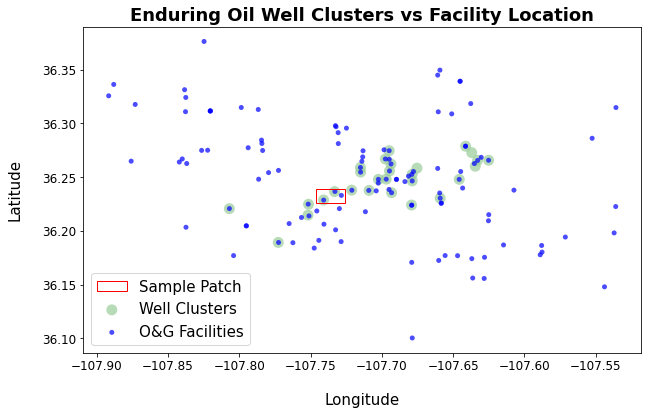

In [0]:
#Create figure
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints of well clusters
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Clusters')

#Plot filtered facilities
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.746, 36.226), width = 0.02, height = 0.013,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Oil Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend([rs_scatter, fac_scatter], ['Oil Well Clusters', 'Facilities'], loc='upper right')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**In order to associate facilities with wells, we need to calculate the distance between each well cluster and the facility. Since the observations occur on Earth's surface, the most appropriate distance metric is Haversine.**

In [0]:
#Haversine function for distance calculation
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

**Calculate the distance between each of the well clusters and the facilities using the Haversine function. If a facility is less than 200 meters away, it is considered associated.**

In [0]:
og_facilities['Cluster'] = np.nan

#Iterate through center points
for i in rs['id'].unique():
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      
    #Too far away to be associated
    else:
      continue

30-045-35503 33314 0.0
30-045-35812 37750 2.0
30-045-35474 33013 3.0
30-045-35725 36213 5.0
30-045-35608 34577 6.0
30-045-35605 34251 7.0
30-045-35776 36658 8.0
30-045-35564 34655 9.0
30-045-35750 36537 10.0
30-045-35743 36617 11.0
30-045-35797 36071 12.0
30-045-35587 33235 13.0
30-045-35496 33272 14.0
30-045-35506 35268 15.0
30-045-35441 32517 16.0
30-045-35727 36461 17.0
30-045-35553 34657 18.0
30-045-35616 34424 19.0
30-045-35643 35260 20.0
30-045-35893 38839 21.0
30-045-35500 32567 22.0
30-045-35754 36843 23.0
30-045-35507 33693 24.0
30-045-35623 34075 25.0
30-045-35639 34892 27.0


In [0]:
#So now we can join the facilities and wells df

df_well_fac = enduring_oil.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['spud_date', 'status', 'id', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'AI', 'Facility Name', 'Cluster', 'Latitude', 'Longitude',
                                  'NO_TPY','CO_TPY','VOC_TPY','PM10_TPY','SO2_TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API',
                                    'AI':'Facility AI'})

#Save as csv
df_well_fac_filter.to_csv('enduring_oil_well_facility_match.csv')

**Visualize all the paired facilities. Note that all the well clusters are included in this plot regardless of if they are paired or not.**

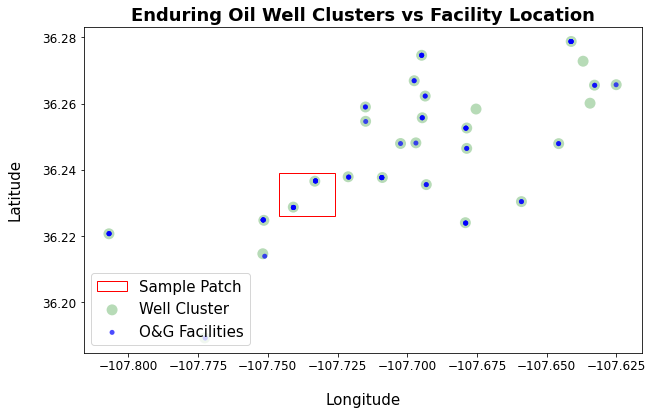

In [0]:
#Plot
fig, ax = plt.subplots(figsize= (10, 6))

#Scatter of well center points
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Cluster')

#Scatter of associated facilities
fac_scatter = ax.scatter(df_well_fac_filter['Facility Longitude'], df_well_fac_filter['Facility Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.746, 36.226), width = 0.02, height = 0.013,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')
ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Oil Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

![Enduring Oil Analysis](https://drive.google.com/uc?id=1ajet1s0B-k4ZE4L89eWBZ0wmGXp9HGLA)

### Hilcorp Gas Analysis

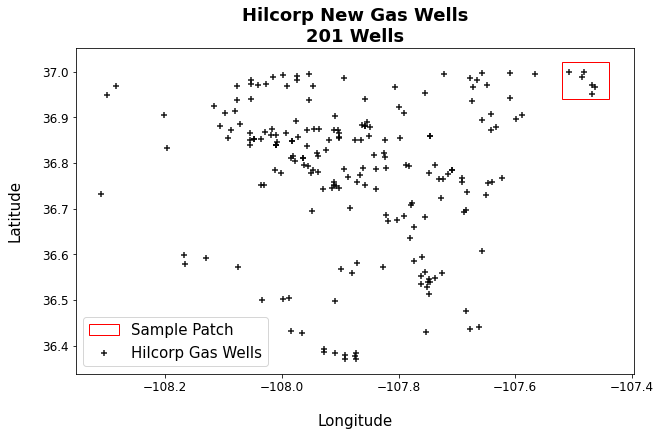

In [0]:
#Plot all new gas wells for enduring
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(hilcorp_gas['longitude'], hilcorp_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Hilcorp Gas Wells')

#Find the number of enduring gas wells
wells = hilcorp_gas.shape[0]

#Format labels
ax.set_title('Hilcorp New Gas Wells\n' + str(wells) + ' Wells', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

rect = patches.Rectangle((-107.52, 36.940), width = 0.08, height = 0.08,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**The next step is to cluster wells together. Clustering is an important step because instead of associating individual wells with facilities, we can associate well clusters (only one point) with facilities. This will cut down the time it takes to run the code in the case of using MANY wells.**

**DBSCAN is a clustering algorithm that groups points together based on their density. We are only only using the coordinates to cluster points, but theoretically you could use other information**

Useful description of DBSCAN for later: https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/

In [0]:
#Matrix of all the well coordinates
coords = hilcorp_gas[['latitude', 'longitude']].values

#DBSCAN requires two inputs other than data: minimum number of samples per cluster and the distance to associate points
kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 190


**Now need to find the centerpoint of all the clusters determined above.**

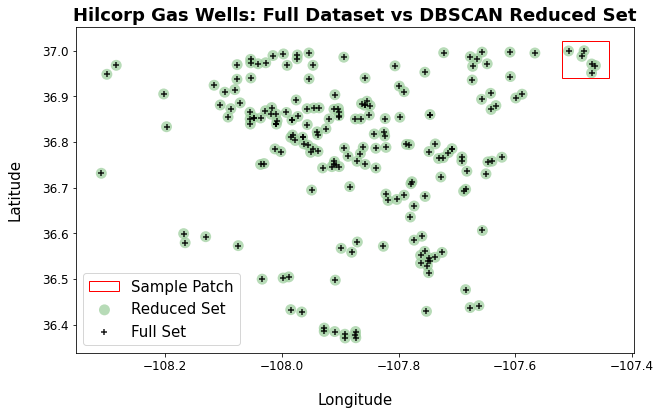

In [0]:
#Function to determine centermost points 
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

#Find centermost points in each cluster
centermost_points = clusters.map(get_centermost_point)

#Save centerpoints as a df
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})


rs = rep_points.apply(lambda row: hilcorp_gas[(hilcorp_gas['latitude']==row['lat'])&(hilcorp_gas['longitude']==row['lon'])].iloc[0], axis=1)

#Create plot
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Reduced Set')

#Plot individual well sites
df_scatter = ax.scatter(hilcorp_gas['longitude'], hilcorp_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Full Set')

#Sample patch
rect = patches.Rectangle((-107.52, 36.940), width = 0.08, height = 0.08,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Hilcorp Gas Wells: Full Dataset vs DBSCAN Reduced Set', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)
ax.legend([df_scatter, rs_scatter], ['Gas Full set', 'Gas Reduced set'], loc='best')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**In the original dataframe of gas wells, we want to know what cluster each observation was assigned to.**

In [0]:
#Empty column to store values
hilcorp_gas['Cluster'] = np.nan

#Iterate through an iterable of length clusters
for i in range(len(clusters)):

  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   hilcorp_gas.loc[(hilcorp_gas['latitude'] == j[0]) & (hilcorp_gas['longitude'] == j[1]), ['Cluster']] = int(i)


#Do the same with our centerpoints of wells. We want to know the cluster number associated with centerpoints.
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

rs.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Unnamed: 0,id,name,type_code,type,status_code,status,ogrid,ogrid_name,district_code,district,county_code,county,ulstr,latitude,longitude,projection,directional_status,details,files,status2,symbology,year_spudded,spud_date,measured_vertical_depth,true_vertical_depth,pool_id_list,effective_date,plug_date,GlobalID,geometry,Cluster
0,667,30-045-34781,O H RANDEL #005H,G,Gas,A,Active,372171,HILCORP ENERGY COMPANY,3,Aztec,45,San Juan,G-10-26N-11W,36.504349,-107.988205,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2011.0,2011-06-23,4461.0,1777.0,[71599] BASIN DAKOTA (PRORATED GAS); [71629] B...,2018-07-12T00:00:00,9999-12-31T00:00:00,{53E5990C-CEE8-4135-A2C4-2C009E8D8960},POINT (-107.988205 36.50434880000006),0.0
1,1064,30-045-35351,SANCHEZ GAS COM B #001F,G,Gas,A,Active,372171,HILCORP ENERGY COMPANY,3,Aztec,45,San Juan,A-28-29N-10W,36.702179,-107.883667,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2013.0,2013-08-15,6512.0,6493.0,[2290] ARMENTA-GALLUP (O); [71599] BASIN DAKOT...,2018-07-12T00:00:00,9999-12-31T00:00:00,{7BA11BEB-27C1-414F-B07B-D325958DAA3C},POINT (-107.8836669999999 36.70217900000006),1.0
2,1393,30-045-35267,HUERFANITO UNIT #088N,G,Gas,A,Active,372171,HILCORP ENERGY COMPANY,3,Aztec,45,San Juan,J-23-27N-09W,36.560230,-107.755302,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2012.0,2012-03-27,6848.0,6842.0,[71599] BASIN DAKOTA (PRORATED GAS); [72319] B...,2017-08-14T00:00:00,9999-12-31T00:00:00,{961D0EA4-63F4-48FE-A166-1B943E9A3A65},POINT (-107.7553023999999 36.56023030000006),2.0
3,1831,30-045-35028,VALENTINE #021H,G,Gas,A,Active,372171,HILCORP ENERGY COMPANY,3,Aztec,45,San Juan,L-21-25N-10W,36.384617,-107.909462,NAD83,H,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2010.0,2010-02-25,5625.0,1635.0,[71629] BASIN FRUITLAND COAL (GAS),2019-07-01T00:00:00,9999-12-31T00:00:00,{D907692A-B55D-4F44-B3AA-E900F8B1F735},POINT (-107.909462 36.38461690000003),3.0
4,1942,30-045-34743,J C GORDON D #001F,G,Gas,A,Active,372171,HILCORP ENERGY COMPANY,3,Aztec,45,San Juan,J-22-27N-10W,36.558296,-107.880325,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2011.0,2011-03-16,6870.0,6790.0,[2170] ANGELS PEAK-GALLUP (ASSOCIATED); [71599...,2018-07-12T00:00:00,9999-12-31T00:00:00,{8C2BFB3D-2892-4093-80D2-286C19D124E2},POINT (-107.8803253 36.55829620000003),4.0


**Now it is time to associate facilities with well clusters. Start by filtering the dataframe of facilities down to ones that are within the general area, are considered oil and gas facilities, and within San Juan County.**

In [0]:
#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

##Filter out outliers by max lat and lon of well locations
#Bottom right: Must be less than or equal to this
max_lon = hilcorp_gas['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = hilcorp_gas['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = hilcorp_gas['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = hilcorp_gas['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

**Visualize well clusters and facilities on the same figure.**

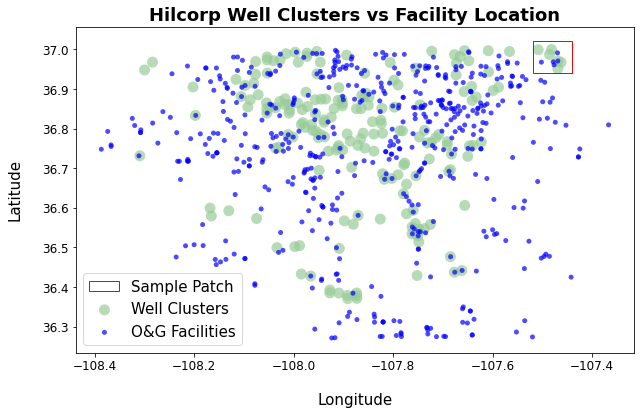

In [0]:
#Create figure
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints of well clusters
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Clusters')

#Plot filtered facilities
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.52, 36.940), width = 0.08, height = 0.08,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Hilcorp Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

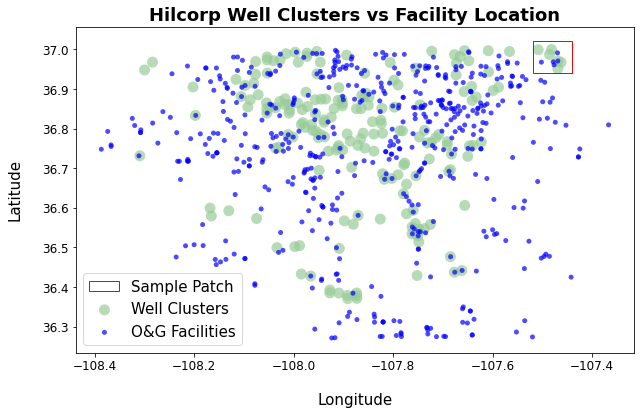

In [0]:
#Create figure
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints of well clusters
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Clusters')

#Plot filtered facilities
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.52, 36.940), width = 0.08, height = 0.08,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Hilcorp Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend(loc= 'lower left', prop = {'size':15})

plt.show()

**In order to associate facilities with wells, we need to calculate the distance between each well cluster and the facility. Since the observations occur on Earth's surface, the most appropriate distance metric is Haversine.**

In [0]:
#Haversine function for distance calculation
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

**Calculate the distance between each of the well clusters and the facilities using the Haversine function. If a facility is less than 200 meters away, it is considered associated.**

In [0]:
og_facilities['Cluster'] = np.nan

#Iterate through center points
for i in rs['id'].unique():
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      
    #Too far away to be associated
    else:
      continue

30-045-35415 31358 8.0
30-045-35436 32123 14.0
30-045-35305 31349 19.0
30-045-35559 39167 23.0
30-045-35360 31878 29.0
30-045-35048 35601 43.0
30-045-35252 36366 46.0
30-045-35167 29776 51.0
30-045-35359 31314 55.0
30-045-35261 31482 66.0
30-045-35452 32508 70.0
30-045-35455 32672 72.0
30-045-35221 32887 74.0
30-045-34950 31310 77.0
30-045-35257 31348 89.0
30-045-35262 31347 95.0
30-045-35382 1305 119.0
30-045-34982 31881 127.0
30-045-35250 31360 130.0
30-045-35287 31311 133.0
30-045-35445 31880 141.0
30-045-34825 31156 142.0
30-045-35016 31155 154.0
30-045-35387 32433 157.0
30-045-35274 1208 160.0
30-045-35229 31480 170.0
30-045-35290 31315 188.0
30-045-35185 31481 189.0


In [0]:
#So now we can join the facilities and wells df

df_well_fac = hilcorp_gas.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['spud_date', 'status', 'id', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'AI', 'Facility Name', 'Cluster', 'Latitude', 'Longitude',
                                  'NO_TPY','CO_TPY','VOC_TPY','PM10_TPY','SO2_TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API',
                                    'AI':'Facility AI'})

#Save as csv
df_well_fac_filter.to_csv('hilcorp_gas_well_facility_match.csv')

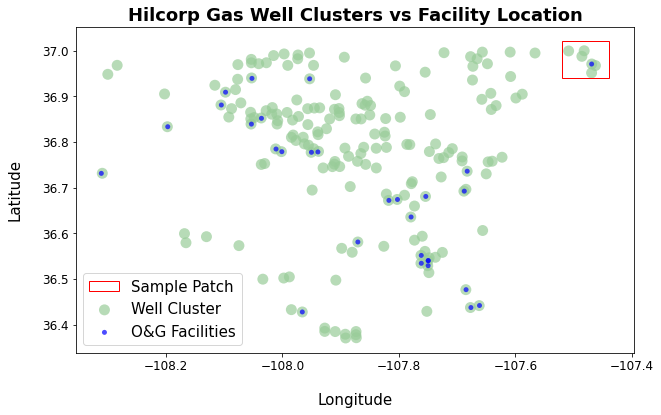

In [0]:
#Plot
fig, ax = plt.subplots(figsize= (10, 6))

#Scatter of well center points
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Cluster')

#Scatter of associated facilities
fac_scatter = ax.scatter(df_well_fac_filter['Facility Longitude'], df_well_fac_filter['Facility Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.52, 36.940), width = 0.08, height = 0.08,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')
ax.add_patch(rect)

#Formatting
ax.set_title('Hilcorp Gas Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

![Hilcorp Gas Analysis](https://drive.google.com/uc?id=1ve4vLReDVEqUkGKbiYi_R0CRuCmbsdV9)

## Matching NOI Info with Facilities and Wells

**Read in all the well cluster and facility matches that we just identified.**

In [0]:
enduring_gas_facwell = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/Updated Facility Well Match (yes spuds)/enduring_gas_well_facility_match.csv')
enduring_oil_facwell = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/Updated Facility Well Match (yes spuds)/enduring_oil_well_facility_match.csv')
hilcorp_oil_facwell = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/Updated Facility Well Match (yes spuds)/hilcorp_gas_well_facility_match.csv')

#Concat them all together
facility_well_match = pd.concat([enduring_gas_facwell, enduring_oil_facwell, hilcorp_oil_facwell])
facility_well_match = facility_well_match.drop(columns = ['Unnamed: 0'])
facility_well_match.head()

#Clean
#Column naming convention
facility_well_match = facility_well_match.rename(columns = {'Initial APD':'initial_apd',
                                                            'Spud Date':'spud_date',
                                                            'Well API':'well_api',
                                                            'Well Name':'well_name',
                                                            'Well Latitude':'well_latitude',
                                                            'Well Longitude':'well_longitude',
                                                            'Facility AI':'facility_ai',
                                                            'Facility Name':'facility_name',
                                                            'Cluster':'cluster',
                                                            'Facility Latitude':'facility_latitude',
                                                            'Facility Longitude':'facility_longitude'})
#Datetime implementation
facility_well_match['initial_apd'] = pd.to_datetime(facility_well_match['initial_apd'])
facility_well_match['spud_date'] = pd.to_datetime(facility_well_match['spud_date'])

#Inspect
facility_well_match.head()

,initial_apd,spud_date,well_api,well_name,ogrid_name,well_latitude,well_longitude,facility_ai,facility_name,cluster,facility_latitude,facility_longitude,NO_TPY,CO_TPY,VOC_TPY,PM10_TPY,SO2_TPY
0,2018-08-31,2018-09-06,30-045-35879,KIMBETO WASH UNIT #767H,"ENDURING RESOURCES, LLC",36.220745,-107.806892,36843,"Enduring Resources - Kimbeto Wash UT No768,769...",0.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN
1,2017-05-26,2017-05-31,30-045-35800,RODEO UNIT #501H,"ENDURING RESOURCES, LLC",36.220442,-107.715623,36842,"Enduring Resources - Rodeo UT No500,501",1.0,36.217803,-107.711514,24.3,24.8,83.8,3.2,NaN
2,2017-05-26,2017-05-31,30-045-35796,RODEO UNIT #500H,"ENDURING RESOURCES, LLC",36.220413,-107.715566,36842,"Enduring Resources - Rodeo UT No500,501",1.0,36.217803,-107.711514,24.3,24.8,83.8,3.2,NaN
3,2018-04-16,2018-09-24,30-045-35869,RODEO UNIT #508H,"ENDURING RESOURCES, LLC",36.200969,-107.733028,38352,Enduring - Rodeo UT No508/509/510,2.0,36.200956,-107.732417,14.6,NaN,81.3,4.0,0.11
4,2018-04-17,2018-09-25,30-045-35871,RODEO UNIT #510H,"ENDURING RESOURCES, LLC",36.200912,-107.732912,38352,Enduring - Rodeo UT No508/509/510,2.0,36.200956,-107.732417,14.6,NaN,81.3,4.0,0.11


**Load and clean NOI data obtained by hand.**

In [0]:
df_noi = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/Facility Permits/noi_info_4172020.csv')

#Clean dataset
#Drop extra rows (we know all rows should have an ai number)
df_noi = df_noi.dropna(subset = ['ai_number'])

#Convert ai number to int
df_noi['ai_number'] = pd.to_numeric(df_noi['ai_number'], downcast = 'integer')

#Clean column names
df_noi = df_noi.rename(columns = {'date_sent_to_nmed (mm/dd/yyyy)':'date_sent_to_nmed'})

#Drop extra columns
df_noi = df_noi.drop(columns = ['gdrive_link', 'comments'])

#Convert dates to datetime
df_noi['date_sent_to_nmed'] = pd.to_datetime(df_noi['date_sent_to_nmed'])
df_noi['date_received'] = pd.to_datetime(df_noi['date_received'])
df_noi['date_sent_to_company'] = pd.to_datetime(df_noi['date_sent_to_company'])

#Inspect
df_noi.head()

,ai_number,facility_name,noi_number,date_sent_to_nmed,date_received,date_sent_to_company
0,31357,Nell Hall 1E,4746,NaT,2012-04-24,2012-04-24
1,31358,Jackson Com 1N,4747,NaT,2012-04-24,2012-04-24
2,31360,Blanco Wash Federal 3M,4748,NaT,2012-04-24,2012-04-24
3,31361,Grenier B 3P,4749,NaT,2012-04-24,2012-04-24
4,31347,Huerfanito Unit 98N,4753,2012-04-16,2012-04-19,2012-05-07


**Join NOI and facility well match dfs.**

In [0]:
df = facility_well_match.merge(df_noi, how = 'outer', left_on = 'facility_ai', right_on = 'ai_number')
df.head()

,initial_apd,spud_date,well_api,well_name,ogrid_name,well_latitude,well_longitude,facility_ai,facility_name_x,cluster,facility_latitude,facility_longitude,NO_TPY,CO_TPY,VOC_TPY,PM10_TPY,SO2_TPY,ai_number,facility_name_y,noi_number,date_sent_to_nmed,date_received,date_sent_to_company
0,2018-08-31,2018-09-06,30-045-35879,KIMBETO WASH UNIT #767H,"ENDURING RESOURCES, LLC",36.220745,-107.806892,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",0.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT
1,2016-05-05,2018-09-07,30-045-35753,KIMBETO WASH UNIT #768H,"ENDURING RESOURCES, LLC",36.220704,-107.806937,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",1.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT
2,2016-05-05,2016-05-19,30-045-35756,KIMBETO WASH UNIT #771H,"ENDURING RESOURCES, LLC",36.220539,-107.807116,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",1.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT
3,2016-05-05,2018-09-06,30-045-35754,KIMBETO WASH UNIT #769H,"ENDURING RESOURCES, LLC",36.220663,-107.806982,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",1.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT
4,2016-05-13,2018-09-05,30-045-35755,KIMBETO WASH UNIT #770H,"ENDURING RESOURCES, LLC",36.220580,-107.807071,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",1.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT


**Function to detect potential violation. Potential violation would be starting the well before obtaining an NOI for the supporting facility.**

In [0]:
def violation_detection(x):
  if x['spud_date'] < x['date_sent_to_company']:
    return 'Yes'

  else:
    return 'No'

**Perform an inner join to match only the facilities that we have looked at the NOI for. Apply the violation detection function.**

In [0]:
#Remove duplicate rows
well_fac = facility_well_match.drop_duplicates()

#Perform inner join
df_complete = df_noi.merge(well_fac, how = 'inner', left_on = 'ai_number', right_on = 'facility_ai')

#Apply violation detection function
df_complete['potential_violation']= df_complete.apply(violation_detection, axis = 1)

#Keep a subset of columns
df = df_complete[['well_name', 'ai_number', 'noi_number', 'well_api', 'initial_apd','spud_date', 'date_sent_to_nmed', 'date_received', 'date_sent_to_company', 'potential_violation']]

#Inspect
df.head()

,well_name,ai_number,noi_number,well_api,initial_apd,spud_date,date_sent_to_nmed,date_received,date_sent_to_company,potential_violation
0,JACKSON COM #001N,31358,4747,30-045-35415,2013-01-08,2014-12-11,NaT,2012-04-24,2012-04-24,No
1,BLANCO WASH FEDERAL #003M,31360,4748,30-045-35250,2011-04-20,2013-04-08,NaT,2012-04-24,2012-04-24,No
2,GRENIER B #003P,31361,4749,30-045-35263,2011-05-17,2014-12-03,NaT,2012-04-24,2012-04-24,No
3,HUERFANITO UNIT #098N,31347,4753,30-045-35262,2011-06-23,2011-11-21,2012-04-16,2012-04-19,2012-05-07,Yes
4,HUERFANITO UNIT #099E,31348,4754,30-045-35257,2011-04-29,2012-03-15,2012-04-18,2012-04-19,2012-05-07,Yes


**Many of the NOIs are actually revisions of an original NOI. All revisions appear to be marked with an "R" in the NOI number. We are interested in the original NOI which is presumed to be for the initial construction of a facility.**

In [0]:
#Remove rows that have a revised noi
df_original_noi = df_complete[~df_complete['noi_number'].str.contains('R')]
df_original_noi_all_columns = df_complete[~df_complete['noi_number'].str.contains('R')]

##Save a cleaned copy as a csv
#Drop duplicate columns
df_original_noi_csv = df_original_noi_all_columns.drop(columns = ['ai_number', 'facility_name_x'])
df_original_noi_csv = df_original_noi_csv.rename(columns = {'facility_name_y':'facility_name'})

#Save as csv with binary value for violations
def yes_no(x):
  if x == 'Yes':
    return 1
  if x == 'No':
    return 0

df_original_noi_csv['binary_violation'] = df_original_noi['potential_violation'].apply(yes_no)
df_original_noi_csv.to_csv('well_facility_violations.csv')

#Filter to only rows that have a potential violation
df_original_noi[df_original_noi['potential_violation'] == 'Yes']

,ai_number,facility_name_x,noi_number,date_sent_to_nmed,date_received,date_sent_to_company,initial_apd,spud_date,well_api,well_name,ogrid_name,well_latitude,well_longitude,facility_ai,facility_name_y,cluster,facility_latitude,facility_longitude,NO_TPY,CO_TPY,VOC_TPY,PM10_TPY,SO2_TPY,potential_violation
3,31347,Huerfanito Unit 98N,4753,2012-04-16,2012-04-19,2012-05-07,2011-06-23,2011-11-21,30-045-35262,HUERFANITO UNIT #098N,HILCORP ENERGY COMPANY,36.528862,-107.750565,31347,Hilcorp - Huerfanito Unit 98N,26.0,36.528889,-107.749886,NaN,NaN,NaN,NaN,NaN,Yes
4,31348,Huerfanito Unit 99E,4754,2012-04-18,2012-04-19,2012-05-07,2011-04-29,2012-03-15,30-045-35257,HUERFANITO UNIT #099E,HILCORP ENERGY COMPANY,36.534225,-107.762260,31348,Hilcorp - Huerfanito Unit 99E,26.0,36.534167,-107.761667,NaN,NaN,NaN,NaN,NaN,Yes
5,31349,Sadie West 2M,4755,2012-04-13,2012-04-19,2012-05-07,2011-09-20,2012-02-23,30-045-35305,SADIE WEST #002M,HILCORP ENERGY COMPANY,36.880913,-108.105629,31349,Hilcorp - Sadie West 2M,26.0,36.880833,-108.105000,NaN,NaN,NaN,NaN,NaN,Yes
8,31155,Sandia Federal 1F,4695,2012-02-03,2012-02-09,2012-03-06,2009-09-18,2011-12-28,30-045-35016,SANDIA FEDERAL #001F,HILCORP ENERGY COMPANY,36.784687,-108.011795,31155,Hilcorp - Sandia Federal 1F,26.0,36.784444,-108.011111,NaN,NaN,NaN,NaN,NaN,Yes
9,31156,Federal C 1M,4696,2012-02-03,2012-02-09,2012-03-01,2008-11-07,2011-12-15,30-045-34825,FEDERAL C #001M,HILCORP ENERGY COMPANY,36.778698,-108.001839,31156,Hilcorp - Federal C 1M,26.0,36.778611,-108.001111,NaN,NaN,NaN,NaN,NaN,Yes
43,33013,WPX Energy - Chaco 2408-36P No 143H,5304,2013-09-27,2013-10-01,2013-10-29,2013-06-06,2013-09-21,30-045-35474,NW LYBROOK UNIT #143H,"ENDURING RESOURCES, LLC",36.265697,-107.625038,33013,"Enduring Resources - NW Lybrook UT No143,132",24.0,36.265681,-107.625069,12.00,22.30,62.80,NaN,NaN,Yes
67,32517,Chaco 2408-32P No. 114H,5122,2013-05-01,2013-05-07,2013-06-05,2012-12-13,2013-01-04,30-045-35441,CHACO 2408 32P #114H,"ENDURING RESOURCES, LLC",36.266895,-107.697495,32517,Enduring Resources Inc - Chaco 2408-32P No114H,20.0,36.266900,-107.697510,14.10,24.30,93.20,1.7,NaN,Yes
99,32567,Chaco 2308-161 No. 147H,5141,2013-05-22,2013-05-24,2013-06-18,2012-12-13,2013-02-20,30-045-35439,CHACO 2308 16I #147H,"ENDURING RESOURCES, LLC",36.223904,-107.679031,32567,Enduring Resources - Chaco 2308-161 No147H,11.0,36.223900,-107.679039,14.10,24.40,93.60,NaN,NaN,Yes
104,35268,WPX - Warner Caldwell No. 3B,6157,2014-12-11,2014-12-22,2014-12-31,2014-02-25,2014-03-10,30-045-35506,WARNER CALDWELL #003B,"ENDURING RESOURCES, LLC",36.247940,-107.702393,35268,Enduring - Warner Caldwell No 3B,13.0,36.247928,-107.702400,20.50,24.40,8.10,NaN,NaN,Yes
107,31480,Hodges 12E,4779,2012-05-18,2012-04-19,2012-06-04,2011-03-16,2012-04-30,30-045-35229,HODGES #012E,HILCORP ENERGY COMPANY,36.437264,-107.677208,31480,Hilcorp - Hodges 12E,26.0,36.437222,-107.676389,NaN,NaN,NaN,NaN,NaN,Yes


**Prepare data for visualizations.**

In [0]:
#Number of original nois
num_og_nois = df_original_noi.shape[0]

#When plotting we want to spread out each "timeline" so multiply by three to make space
df_original_noi['Plotting Line'] = np.arange(0,num_og_nois*3, 3)

#Find the index positions of the violations. Use the "plotting line" based index
violation_lines = df_original_noi[df_original_noi['potential_violation'] == 'Yes']['Plotting Line']

#Find the minimum date and the maximum date overall
min_date = np.min([df_original_noi['date_sent_to_nmed'].min(), df_original_noi['spud_date'].min(), df_original_noi['date_received'].min(), df_original_noi['date_sent_to_company'].min()])
max_date = np.max([df_original_noi['date_sent_to_nmed'].max(), df_original_noi['spud_date'].max(), df_original_noi['date_received'].max(), df_original_noi['date_sent_to_company'].max()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


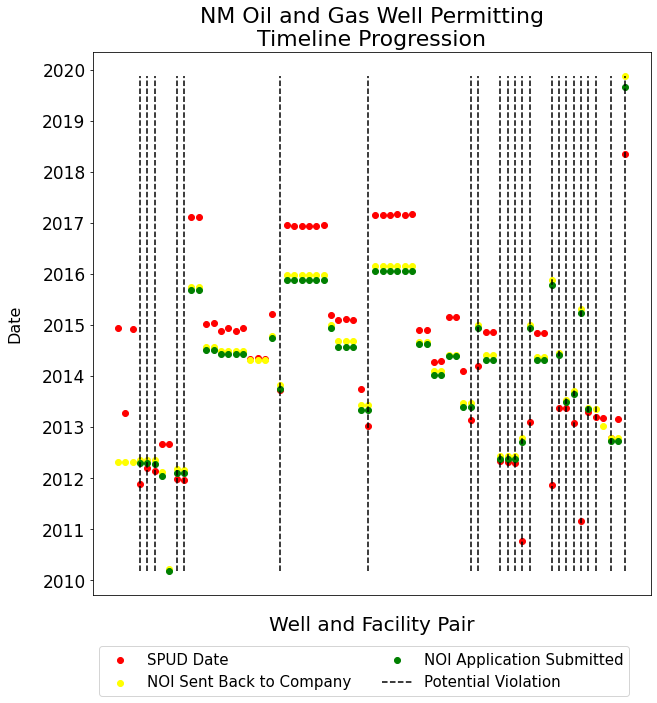

In [0]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['spud_date'], color = 'Red', label = 'SPUD Date')
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['date_sent_to_company'], color = 'Yellow', label = 'NOI Sent Back to Company')
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['date_sent_to_nmed'], color = 'Green', label = 'NOI Application Submitted')

ax.vlines(violation_lines.values, ymin = min_date, ymax = max_date, linestyles = 'dashed', color = 'black', label = 'Potential Violation')

ax.set_ylabel('Date', size = 16, labelpad = 20)
ax.set_xlabel('Well and Facility Pair', size = 20, labelpad = 20)
ax.set_title('NM Oil and Gas Well Permitting\nTimeline Progression', size = 22)
ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
plt.xticks([])

plt.legend(ncol = 2, prop = {'size':15}, bbox_to_anchor = (0.975,-0.08), fancybox = True)

plt.savefig('violations.jpg', bbox_inches = 'tight')

In [0]:
#Percent of violations
df_original_noi[df_original_noi['potential_violation'] == 'Yes'].shape[0] / df_original_noi.shape[0]

0.32857142857142857

In [0]:
df_original_noi.head()

,ai_number,facility_name_x,noi_number,date_sent_to_nmed,date_received,date_sent_to_company,initial_apd,spud_date,well_api,well_name,ogrid_name,well_latitude,well_longitude,facility_ai,facility_name_y,cluster,facility_latitude,facility_longitude,NO_TPY,CO_TPY,VOC_TPY,PM10_TPY,SO2_TPY,potential_violation,Plotting Line
0,31358,Jackson Com 1N,4747,NaT,2012-04-24,2012-04-24,2013-01-08,2014-12-11,30-045-35415,JACKSON COM #001N,HILCORP ENERGY COMPANY,36.673992,-107.803062,31358,Hilcorp - Jackson Com 1N,26.0,36.673889,-107.802500,NaN,NaN,NaN,NaN,NaN,No,0
1,31360,Blanco Wash Federal 3M,4748,NaT,2012-04-24,2012-04-24,2011-04-20,2013-04-08,30-045-35250,BLANCO WASH FEDERAL #003M,HILCORP ENERGY COMPANY,36.635509,-107.779709,31360,Hilcorp - Blanco Wash Federal 3M,26.0,36.635556,-107.779167,NaN,NaN,NaN,NaN,NaN,No,3
2,31361,Grenier B 3P,4749,NaT,2012-04-24,2012-04-24,2011-05-17,2014-12-03,30-045-35263,GRENIER B #003P,HILCORP ENERGY COMPANY,36.750061,-107.907532,31361,Hilcorp - Grenier B 3P,26.0,36.750000,-107.906944,NaN,NaN,NaN,NaN,NaN,No,6
3,31347,Huerfanito Unit 98N,4753,2012-04-16,2012-04-19,2012-05-07,2011-06-23,2011-11-21,30-045-35262,HUERFANITO UNIT #098N,HILCORP ENERGY COMPANY,36.528862,-107.750565,31347,Hilcorp - Huerfanito Unit 98N,26.0,36.528889,-107.749886,NaN,NaN,NaN,NaN,NaN,Yes,9
4,31348,Huerfanito Unit 99E,4754,2012-04-18,2012-04-19,2012-05-07,2011-04-29,2012-03-15,30-045-35257,HUERFANITO UNIT #099E,HILCORP ENERGY COMPANY,36.534225,-107.762260,31348,Hilcorp - Huerfanito Unit 99E,26.0,36.534167,-107.761667,NaN,NaN,NaN,NaN,NaN,Yes,12


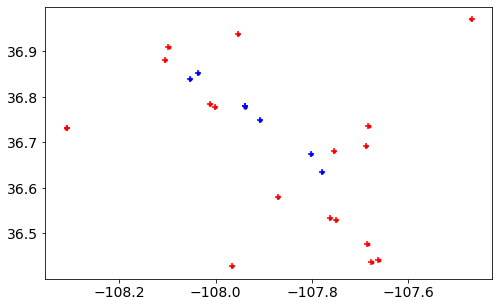

In [0]:
noi_yes_violations = df_original_noi[(df_original_noi['potential_violation'] == 'Yes') & (df_original_noi['ogrid_name'] == 'HILCORP ENERGY COMPANY')]
noi_no_violations = df_original_noi[(df_original_noi['potential_violation'] == 'No') & (df_original_noi['ogrid_name'] == 'HILCORP ENERGY COMPANY')]

fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(noi_yes_violations['facility_longitude'], noi_yes_violations['facility_latitude'], marker = '.', color = 'red')
ax.scatter(noi_no_violations['facility_longitude'], noi_no_violations['facility_latitude'], marker = '.', color = 'blue')

ax.scatter(noi_yes_violations['well_longitude'], noi_yes_violations['well_latitude'], marker = '+', color = 'red')
ax.scatter(noi_no_violations['well_longitude'], noi_no_violations['well_latitude'], marker = '+', color = 'blue')

# #Plot all new gas wells for enduring
# fig, ax = plt.subplots(figsize=[10, 6])
# df_scatter = ax.scatter(hilcorp_gas['longitude'], hilcorp_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Hilcorp Gas Wells')

# #Find the number of enduring gas wells
# wells = hilcorp_gas.shape[0]

# #Format labels
# ax.set_title('Hilcorp New Gas Wells\n' + str(wells) + ' Wells', size = 18, fontweight = 'bold')
# ax.set_xlabel('Longitude', size = 15, labelpad = 20)
# ax.set_ylabel('Latitude', size = 15, labelpad = 20)
# ax.tick_params(labelsize = 12)

# rect = patches.Rectangle((-107.52, 36.940), width = 0.08, height = 0.08,
#                          linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

# ax.add_patch(rect)

# ax.legend(loc= 'lower left', prop = {'size':15})
# plt.show()